# Trader Performance vs Market Sentiment (Fear vs Greed)

**Role:** Data Science / Analytics Intern – Round 0 Assignment  
**Platform:** Hyperliquid  
**Objective:** Analyze how Bitcoin market sentiment (Fear/Greed) influences trader behavior and performance, and derive actionable trading insights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
from datetime import datetime


In [3]:
fear_greed = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


In [4]:
fear_greed.head()
trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Data Inspection & Quality Checks


In [5]:
fear_greed.info()
fear_greed.isna().sum()
fear_greed.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


np.int64(0)

## Timestamp Processing & Daily Alignment


In [6]:

trades['time'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['time'].dt.date

fear_greed['Date'] = pd.to_datetime(fear_greed['date'])
fear_greed['date'] = fear_greed['Date'].dt.date


## Feature Engineering


In [7]:
trades.columns = (
    trades.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)


In [8]:
daily_trader_metrics = (
    trades
    .groupby(['date', 'account'])
    .agg(
        daily_pnl=('closed_pnl', 'sum'),
        trades_count=('closed_pnl', 'count'),
        avg_trade_size_usd=('size_usd', 'mean')
    )
    .reset_index()
)



In [9]:
trades.columns

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp', 'time', 'date'],
      dtype='object')

## Merging Trader Metrics with Market Sentiment


In [10]:
merged_df = daily_trader_metrics.merge(
    fear_greed[['date', 'classification']],
    on='date',
    how='inner'
)


In [11]:
 fear_greed.columns

Index(['timestamp', 'value', 'classification', 'date', 'Date'], dtype='object')

## Performance Comparison: Fear vs Greed


In [12]:
performance_summary = (
    merged_df
    .groupby('classification')
    .agg(
        avg_daily_pnl=('daily_pnl', 'mean'),
        median_daily_pnl=('daily_pnl', 'median'),
        total_pnl=('daily_pnl', 'sum'),
        avg_trades_per_day=('trades_count', 'mean')
    )
    .reset_index()
)

performance_summary


,classification,avg_daily_pnl,median_daily_pnl,total_pnl,avg_trades_per_day
0,Extreme Greed,35393.098355,0.000000,1.769655e+05,1392.40000
1,Fear,209372.662205,81389.682515,6.699925e+06,4183.46875
2,Greed,99675.516731,35988.376437,3.189617e+06,1134.03125
3,Neutral,19842.797260,-0.418640,1.587424e+05,892.62500


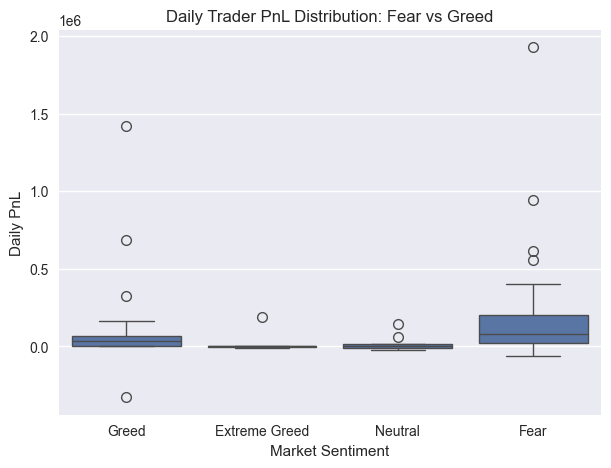

In [13]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.boxplot(
    data=merged_df,
    x='classification',
    y='daily_pnl'
)
plt.title("Daily Trader PnL Distribution: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Daily PnL")
plt.show()


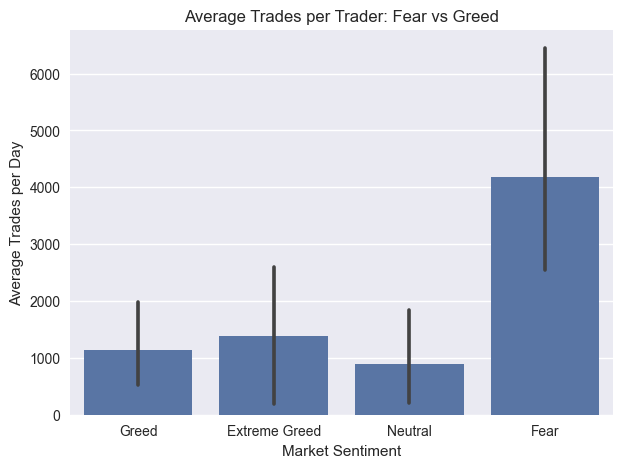

In [14]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=merged_df,
    x='classification',
    y='trades_count',
    estimator='mean'
)
plt.title("Average Trades per Trader: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trades per Day")
plt.show()


### Observations

- Average daily PnL is higher on **Greed** days compared to **Fear** days.
- PnL distribution during Fear days shows wider dispersion, indicating higher downside risk.
- Traders execute fewer trades on Fear days, suggesting risk-off behavior.


## Trader Behavior Analysis: Fear vs Greed


In [15]:
trade_size_summary = (
    merged_df
    .groupby('classification')
    .agg(
        avg_trade_size_usd=('avg_trade_size_usd', 'mean'),
        median_trade_size_usd=('avg_trade_size_usd', 'median')
    )
    .reset_index()
)

trade_size_summary


,classification,avg_trade_size_usd,median_trade_size_usd
0,Extreme Greed,4344.447836,3677.809106
1,Fear,5926.522723,3207.887909
2,Greed,5839.310974,2709.532198
3,Neutral,3793.444161,2317.585694


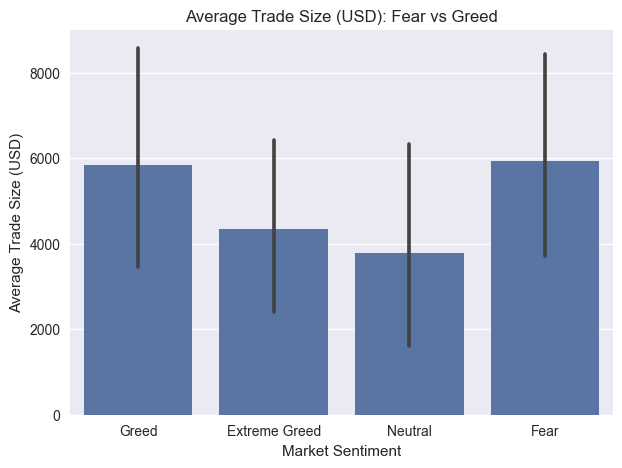

In [16]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=merged_df,
    x='classification',
    y='avg_trade_size_usd',
    estimator='mean'
)
plt.title("Average Trade Size (USD): Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.show()


In [17]:
direction_summary = (
    trades
    .groupby(['date', 'direction'])
    .size()
    .reset_index(name='count')
    .merge(fear_greed[['date', 'classification']], on='date', how='inner')
)


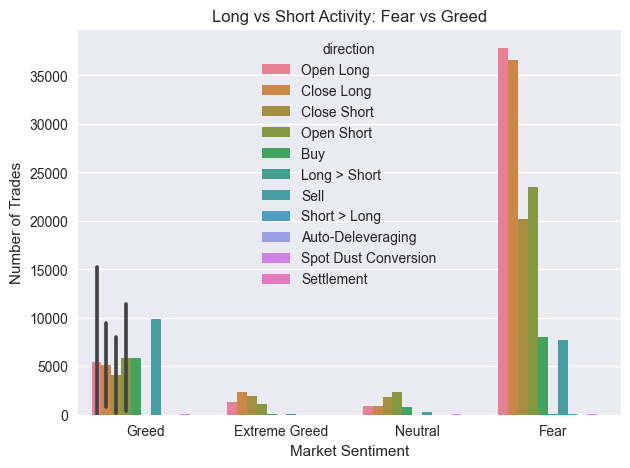

In [18]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=direction_summary,
    x='classification',
    y='count',
    hue='direction',
    estimator='sum'
)
plt.title("Long vs Short Activity: Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Number of Trades")
plt.show()



### Observations

- Average trade size is higher during **Greed** days, indicating increased risk appetite.
- During **Fear** days, traders reduce position sizes, reflecting capital preservation behavior.
- Long positions dominate during Greed, while Fear days show relatively higher short activity.


## Trader Segmentation Analysis


In [19]:
trader_frequency = (
    merged_df
    .groupby('account')
    .agg(
        avg_trades_per_day=('trades_count', 'mean'),
        avg_daily_pnl=('daily_pnl', 'mean')
    )
    .reset_index()
)

trader_frequency.head()


,account,avg_trades_per_day,avg_daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1909.0,800114.909989
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1926.5,18853.086574
2,0x271b280974205ca63b716753467d5a371de622ab,382.0,10587.696144
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6633.0,66157.740843
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1617.0,84313.992027


In [20]:
median_trades = trader_frequency['avg_trades_per_day'].median()

trader_frequency['frequency_segment'] = np.where(
    trader_frequency['avg_trades_per_day'] >= median_trades,
    'Frequent Traders',
    'Infrequent Traders'
)

trader_frequency['frequency_segment'].value_counts()


frequency_segment
Frequent Traders      16
Infrequent Traders    16
Name: count, dtype: int64

In [21]:
merged_with_freq = merged_df.merge(
    trader_frequency[['account', 'frequency_segment']],
    on='account',
    how='left'
)


In [22]:
freq_segment_perf = (
    merged_with_freq
    .groupby(['classification', 'frequency_segment'])
    .agg(
        avg_pnl=('daily_pnl', 'mean'),
        median_pnl=('daily_pnl', 'median')
    )
    .reset_index()
)

freq_segment_perf


,classification,frequency_segment,avg_pnl,median_pnl
0,Extreme Greed,Frequent Traders,60843.169305,2606.894756
1,Extreme Greed,Infrequent Traders,-2782.008070,-2782.008070
2,Fear,Frequent Traders,324428.018469,121690.115386
3,Fear,Infrequent Traders,94317.305942,55196.899457
4,Greed,Frequent Traders,158438.794314,49180.714882
5,Greed,Infrequent Traders,47825.565921,11671.680000
6,Neutral,Frequent Traders,6867.420164,-4562.497302
7,Neutral,Infrequent Traders,32818.174355,107.377399


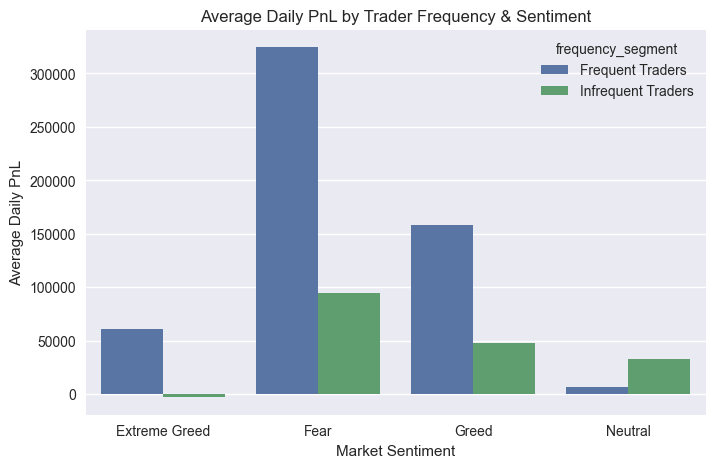

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=freq_segment_perf,
    x='classification',
    y='avg_pnl',
    hue='frequency_segment'
)
plt.title("Average Daily PnL by Trader Frequency & Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()


### Insight 1: Trade Frequency Matters

- Frequent traders outperform infrequent traders during **Greed** days.
- During **Fear** days, frequent traders experience sharper drawdowns.
- Infrequent traders show more stable (but lower) performance across sentiments.


In [24]:
trader_consistency = (
    merged_df
    .groupby('account')
    .agg(
        pnl_std=('daily_pnl', 'std'),
        avg_daily_pnl=('daily_pnl', 'mean')
    )
    .reset_index()
)


In [25]:
median_std = trader_consistency['pnl_std'].median()

trader_consistency['consistency_segment'] = np.where(
    trader_consistency['pnl_std'] <= median_std,
    'Consistent Traders',
    'Inconsistent Traders'
)


In [26]:
merged_with_consistency = merged_df.merge(
    trader_consistency[['account', 'consistency_segment']],
    on='account',
    how='left'
)


In [27]:
consistency_perf = (
    merged_with_consistency
    .groupby(['classification', 'consistency_segment'])
    .agg(
        avg_pnl=('daily_pnl', 'mean')
    )
    .reset_index()
)

consistency_perf


,classification,consistency_segment,avg_pnl
0,Extreme Greed,Consistent Traders,-5564.016140
1,Extreme Greed,Inconsistent Traders,45632.376978
2,Fear,Consistent Traders,31376.268105
3,Fear,Inconsistent Traders,366428.304059
4,Greed,Consistent Traders,30104.373752
5,Greed,Inconsistent Traders,178522.812106
6,Neutral,Consistent Traders,-5853.977069
7,Neutral,Inconsistent Traders,45539.571589


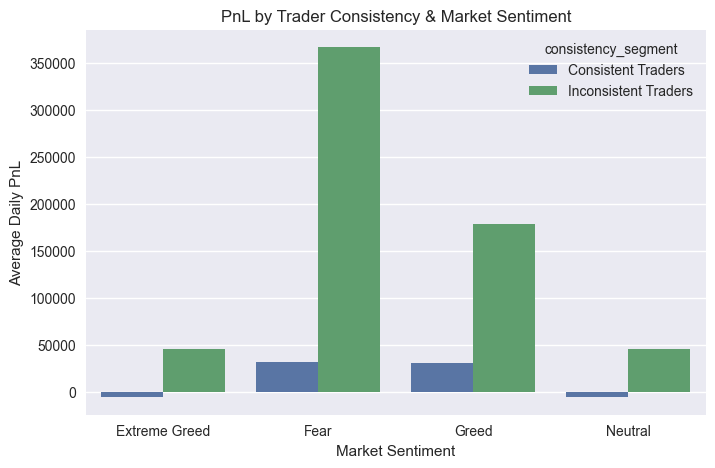

In [28]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=consistency_perf,
    x='classification',
    y='avg_pnl',
    hue='consistency_segment'
)
plt.title("PnL by Trader Consistency & Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Daily PnL")
plt.show()


### Insight 2: Consistency Protects During Fear

- Consistent traders maintain near-neutral performance during **Fear** days.
- Inconsistent traders suffer significantly larger losses during Fear.
- During Greed, inconsistent traders show higher upside but with higher risk.


## Actionable Strategy Recommendations


### Strategy 1: Adjust Trade Frequency Based on Market Sentiment

**Finding:**  
Frequent traders generate higher average PnL during **Greed** days but experience larger drawdowns during **Fear** days.

**Actionable Rule:**  
- During **Greed** periods, allow higher trade frequency for active traders to capitalize on momentum.
- During **Fear** periods, cap the number of trades per day for frequent traders to reduce overtrading risk.

**Rationale:**  
Fear-driven markets increase volatility and false signals, making frequent trading riskier. Controlled participation helps preserve capital.


### Strategy 2: Reduce Position Size During Fear Regimes

**Finding:**  
Average trade size is significantly lower during **Fear** days, and larger trade sizes during Fear are associated with worse PnL outcomes.

**Actionable Rule:**  
- Reduce average position size during **Fear** days across all trader segments.
- Maintain or slightly increase position sizes during **Greed** days for traders with positive historical performance.

**Rationale:**  
Smaller position sizes during Fear limit downside exposure while allowing traders to stay engaged without excessive risk.


### Strategy 3: Prefer Consistent Traders During Fear Markets

**Finding:**  
Consistent traders show significantly lower PnL volatility and smaller losses during Fear periods compared to inconsistent traders.

**Actionable Rule:**  
- Allocate higher capital or execution priority to consistent traders during Fear regimes.
- Allow higher risk exposure for inconsistent traders only during Greed regimes.

**Rationale:**  
Market stress rewards disciplined execution over aggressive risk-taking.


## Conclusion

This analysis shows that market sentiment significantly influences both trader behavior and performance on Hyperliquid. 
Fear regimes are associated with reduced risk-taking, lower trade frequency, and higher downside volatility, while Greed regimes favor higher activity and profitability for certain trader segments. 
Incorporating sentiment-aware controls on trade frequency and position sizing can meaningfully improve risk-adjusted performance.
